


# <h1><center>`Projet d'études sur le Big data Architecture`</center></h1>                        


.

In [1]:
import pyspark
from pyspark.sql.types import StructType,StructField, StringType, IntegerType, DoubleType
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import itertools
from operator import itemgetter
from geopy.distance import distance
from geopy.distance import geodesic
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter
%matplotlib inline


spark = SparkSession.builder.master("local[*]") \
                    .appName('SparkSNCF') \
                    .getOrCreate()

sc = spark.sparkContext

print('Spark CPU usage :', sc.defaultParallelism)

Spark CPU usage : 4


# I

## Trier les gares par nombre d'objets perdus 

In [2]:
data = sc.textFile("sncf-lost-data-2020.csv") \
        .map(lambda line: line.split(";")) \
        .map(lambda line: (line[2], 1)) \
        .reduceByKey(lambda a, b: a + b) \
        .sortBy (lambda pair: pair[1], ascending = False) \
        .collect()

for i in data:
    print ("gare:" ,i[0], "\t\t\t\t\t", "nombre:", i[1])


gare: Paris Gare de Lyon 					 nombre: 5499
gare: Paris Montparnasse 					 nombre: 5371
gare: Paris Gare du Nord 					 nombre: 2727
gare: Bordeaux Saint-Jean 					 nombre: 2689
gare: Rennes 					 nombre: 2497
gare: Marseille Saint-Charles 					 nombre: 2279
gare: Strasbourg 					 nombre: 2105
gare: Lille Europe 					 nombre: 2047
gare: Nantes 					 nombre: 1967
gare: Paris Saint-Lazare 					 nombre: 1942
gare: Lyon Perrache 					 nombre: 1753
gare: Brest 					 nombre: 1549
gare: Toulouse Matabiau 					 nombre: 1440
gare: Mulhouse 					 nombre: 1278
gare: Tours 					 nombre: 1201
gare: Lyon Part Dieu 					 nombre: 1157
gare: Hendaye 					 nombre: 1131
gare: Paris Est 					 nombre: 1092
gare: Montpellier Saint-Roch 					 nombre: 1084
gare: Grenoble 					 nombre: 1003
gare: La Rochelle 					 nombre: 980
gare: Nice 					 nombre: 936
gare: Quimper 					 nombre: 816
gare: Dijon 					 nombre: 709
gare: Orléans 					 nombre: 654
gare: Le Mans 					 nombre: 629
gare: Nancy 					 nombre: 582
gar

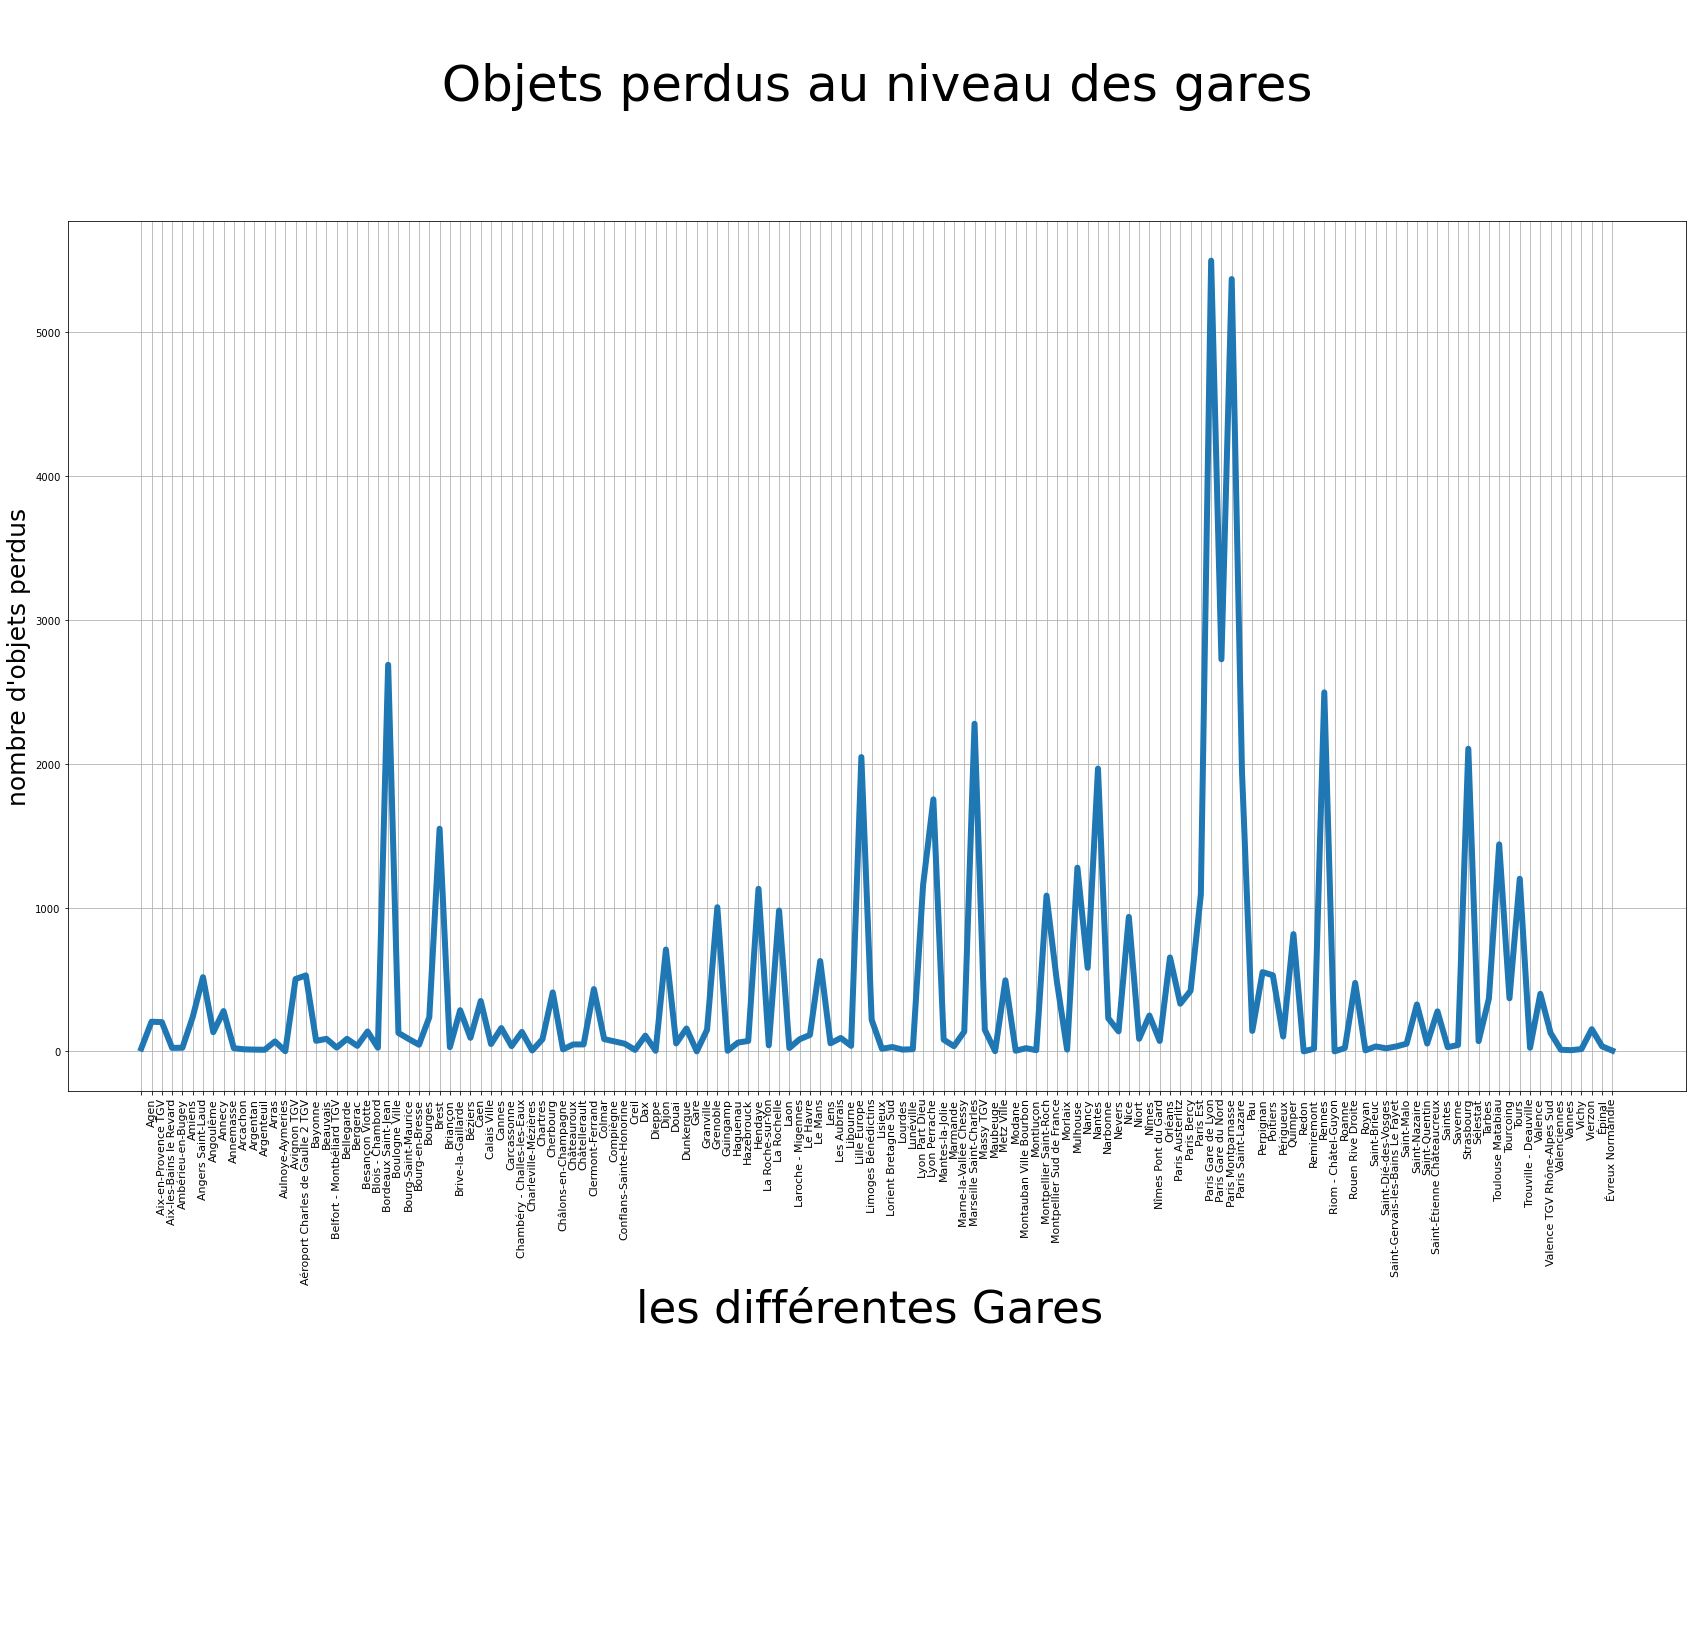

In [3]:
import matplotlib.pyplot as plt
plt.figure (figsize=(29, 16))
data1 = dict(data)
liste = data1.items()
liste = sorted (liste)
x, y = zip(*liste)

plt.plot(x, y, lw = 6)
plt.xlabel('les différentes Gares \n\n\n\n\n\n', fontsize = 45)
plt.ylabel('nombre d\'objets perdus', fontsize = 25)
plt.title('\n Objets perdus au niveau des gares \n\n', fontsize = 50)
plt.xticks(rotation='vertical', fontsize = 11)
plt.grid()

plt.show()

## Trier les gares par temps d'attente > 1h en 2019

In [4]:
def linecheck (colonnes):
    return "2019" in colonnes[2] and colonnes[4] != '' and float(colonnes[4]) > 1.0 

data_1 = sc.textFile("attente-au-guichet.csv") \
        .map(lambda line: line.split(";")) \
        .filter(linecheck) \
        .map(lambda line: (line[0], float(line[4]))) \
        .reduceByKey(lambda a, b: a + b) \
        .sortBy (lambda pair: pair[1], ascending = True) \
        .collect()

for i in data_1 :
    print ("gare:" ,i[0], "\t\t\t\t\t", "nombre:", i[1])

gare: NEV Gare de Paris Montparnasse 					 nombre: 334.0
gare: Gare de Bordeaux St Jean 					 nombre: 1266.0
gare: NEC Paris Gare du Nord 					 nombre: 1570.0
gare: Gare de Strasbourg 					 nombre: 1749.0
gare: Gare de Paris Saint Lazare 					 nombre: 4742.0
gare: Gare Paris Est Alsace 					 nombre: 5340.0
gare: Paris Gare de Lyon Fresque 					 nombre: 7012.0


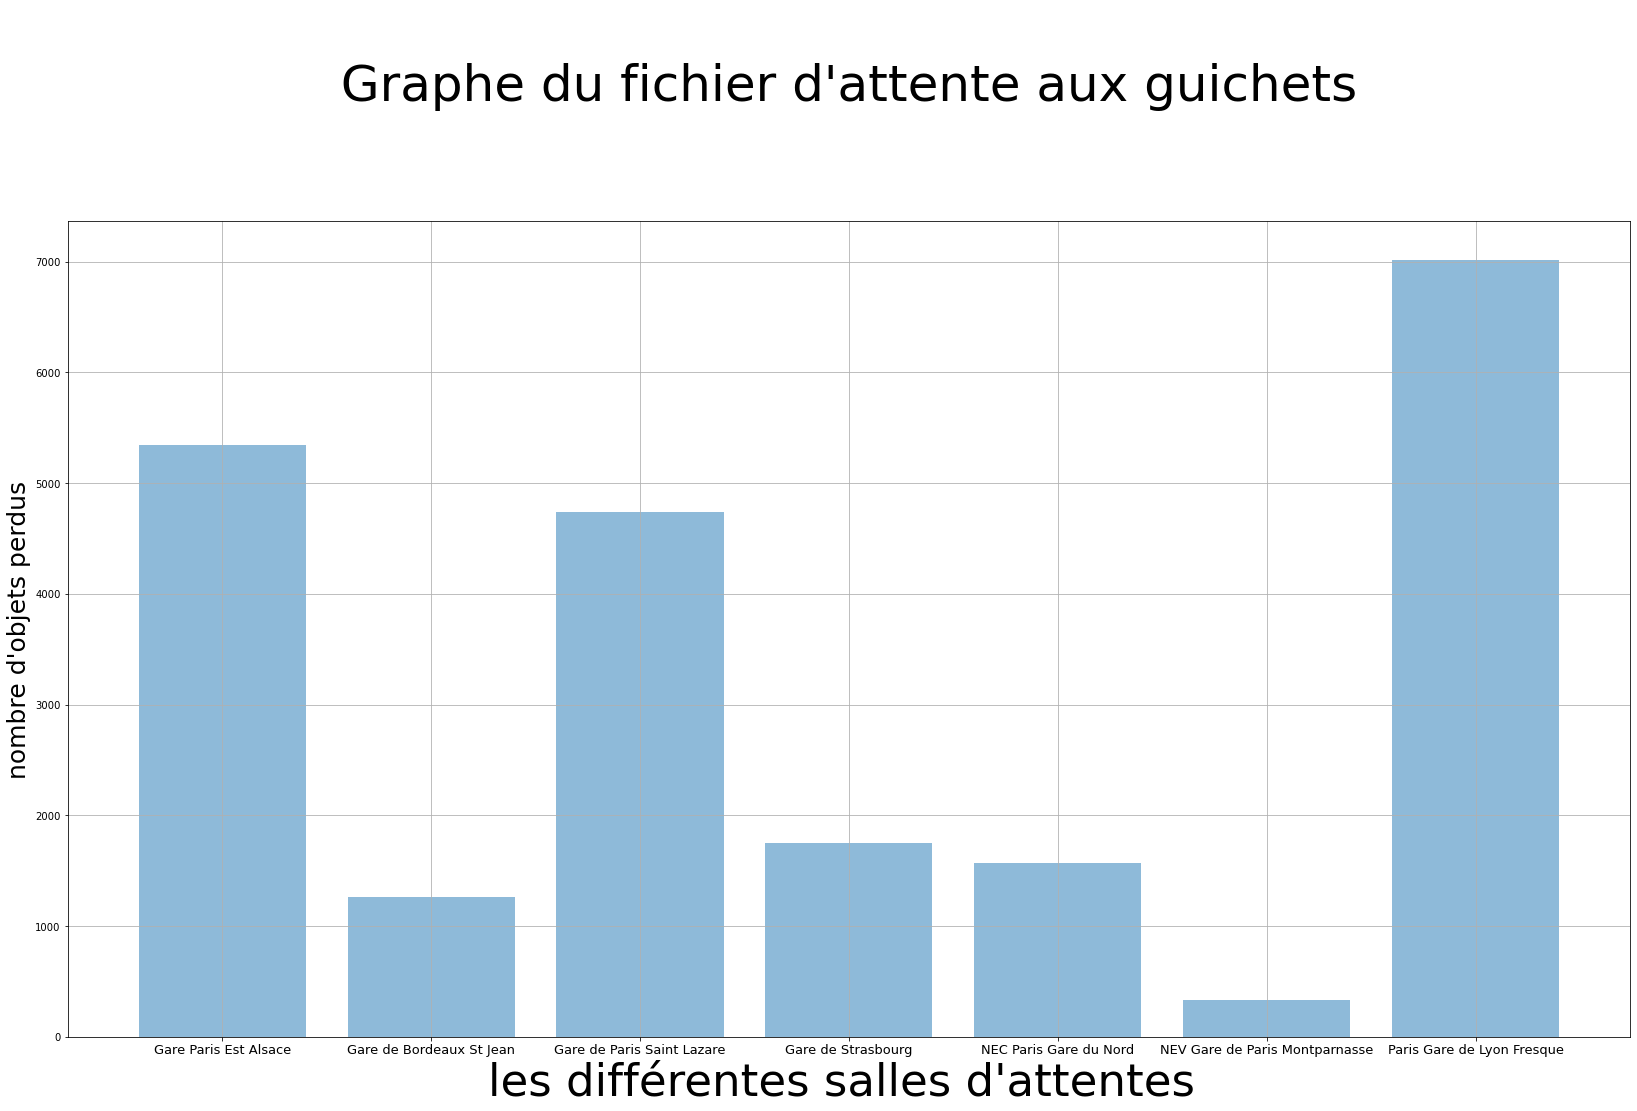

In [5]:
import matplotlib.pyplot as plt
plt.figure (figsize=(28, 15))
data_1 = dict(data_1)
liste_1 = data_1.items()
liste_1 = sorted (liste_1)
x_1, y_1 = zip(*liste_1)

plt.bar(x_1, y_1, alpha = 0.5)
plt.xlabel('les différentes salles d\'attentes ', fontsize = 45)
plt.ylabel('nombre d\'objets perdus', fontsize = 25)
plt.title('\n Graphe du fichier d\'attente aux guichets \n\n', fontsize = 50)
plt.xticks(rotation='horizontal', fontsize = 13)
plt.grid()
plt.show()

# II



## <h1><center>` 1. créer une fonction itineraryPrice (station1, station2) qui estimera le prix du trajet en 1ère classe entre les 2 noms de gares passés en paramètres `</center></h1>


* #### cette fonction devra utiliser PySpark pour exploiter les datasets choisis

* #### lister 4 résultats d'appels de cette fonction avec des gares différentes pour chaque appel


* #### la fonction devra retourner None dans le cas où :


     * les gares passés en paramètre n'existent pas    
     * le prix pour le trajet est inexistant



In [6]:
data_2 = sc.textFile("liste-des-gares.csv") \
        .map (lambda line: line.split(";")) \
        .map (lambda line: (line[1], line[13], line[14])) \
        .sortBy (lambda pair: pair[0], ascending = True)
        
        
data_2 = dict( data_2.map (lambda line: (line[0], [line[1], line[2]])).collect())
data_2

{'Abancourt': ['1.774718285053579', '49.68553371297622'],
 'Abbaretz': ['-1.524313466657773', '47.55546171193697'],
 'Abbeville': ['1.821026233063388', '50.10514547847399'],
 'Ablon': ['2.417931573714535', '48.72396312662991'],
 'Acheux-Franleu': ['1.657174350378938', '50.08247940983747'],
 'Achiet': ['2.780622102331761', '50.13214093061863'],
 'Achères-Grand-Cormier': ['2.092094579250713', '48.95528483926228'],
 'Achères-Ville': ['2.077781536261871', '48.970114458751645'],
 'Agay': ['6.856647145663769', '43.431591083348685'],
 'Agde': ['3.466954502196854', '43.31752183840884'],
 'Agen': ['0.621048372800292', '44.208341089900124'],
 'Agonac': ['0.748705624293986', '45.286590073064275'],
 'Aguilcourt-Variscourt': ['3.973514617883735', '49.40685314473819'],
 'Aiffres': ['-0.42144752662806', '46.28233694979594'],
 'Aigrefeuille-Le Thou': ['-0.952083708878203', '46.09393484633778'],
 'Aiguebelette-le-Lac': ['5.813156640721789', '45.53622016446212'],
 'Aiguebelle': ['6.306820208917644', '45

In [7]:
len(data_2)

3472

In [8]:
data_1 = sc.textFile("bareme-de-prix-national-ter.csv") \
        .map (lambda line: line.split(";")) \
        .map (lambda line: (line[0], line[1], line[2])) \
        .filter (lambda line: line[0] == "1 ère") \
        .sortBy (lambda pair: pair[1], ascending = True) 
        
        


data_1 = dict( data_1.map (lambda line: (line[1], line[2])).collect())
data_1

{'1': '1.8',
 '10': '4.1',
 '100': '26.7',
 '1000': '161.6',
 '101': '26.9',
 '1010': '162.8',
 '102': '27.2',
 '1020': '163.9',
 '103': '27.4',
 '1030': '165.0',
 '104': '27.6',
 '1040': '166.2',
 '105': '27.8',
 '1050': '167.3',
 '106': '28.1',
 '1060': '168.4',
 '107': '28.3',
 '1070': '169.6',
 '108': '28.5',
 '1080': '170.7',
 '109': '28.7',
 '1090': '171.8',
 '11': '4.4',
 '110': '29.7',
 '1100': '173.0',
 '111': '29.9',
 '1110': '174.1',
 '112': '30.1',
 '1120': '175.2',
 '113': '30.3',
 '1130': '176.4',
 '114': '30.5',
 '1140': '177.5',
 '115': '30.8',
 '1150': '178.6',
 '116': '31.0',
 '1160': '179.8',
 '117': '31.2',
 '1170': '180.9',
 '118': '31.4',
 '1180': '182.0',
 '119': '31.6',
 '1190': '183.2',
 '12': '4.7',
 '120': '31.8',
 '1200': '184.3',
 '121': '32.0',
 '1210': '185.4',
 '122': '32.3',
 '1220': '186.6',
 '123': '32.5',
 '1230': '187.7',
 '124': '32.7',
 '1240': '188.8',
 '125': '32.9',
 '1250': '190.0',
 '126': '33.1',
 '1260': '191.1',
 '127': '33.3',
 '1270': '1

##### <center><h1>`création de la fonction itineraryPrice (station1, station2)`</center></h1>




<center><h3> distance = R (π/2-arcsin(sin(latD)×sin(latO)+cos(longD-longO)×cos(latD)×cos(latO))) </center></h3>    
    
        


In [9]:
def itinerary_Price (station_1, station_2):

    Gares = sc.textFile("liste-des-gares.csv") \
            .map(lambda line: line.split(";")) \
            .map(lambda line: (line[1], line[13], line[14])) \
            .sortBy (lambda pair: pair[0], ascending = False)
    Gares = dict( Gares.map (lambda line: (line[0], [line[1], line[2]])).collect())
    
    prix = sc.textFile("bareme-de-prix-national-ter.csv") \
            .map (lambda line: line.split(";")) \
            .map (lambda line: (line[0], line[1], line[2])) \
            .filter (lambda line: line[0] == "1 ère") \
            .sortBy (lambda pair: pair[0], ascending = True) 

    prix = dict( prix.map (lambda line: (line[1], line[2])).collect())
    
    if station_1 not in Gares.keys():
        print ("None")
        return None
        
    elif station_2 not in Gares.keys():
        print ("None")
        return None
    
    
    for i in Gares.keys():
        if i == station_1:
            lon_1 = Gares[i][0] 
            lat_1 = Gares[i][1]
         
        
    for j in Gares.keys():
        if station_2 == j:
            lon_2 = Gares[j][0] 
            lat_2 = Gares[j][1]
        
        
    p = 0.017453292519943295 # Pi/180
    a = 0.5 - np.cos((float(lat_2) - float(lat_1)) * p)/2 + np.cos(float(lat_1) * p) * np.cos(float(lat_2) * p) * (1 - np.cos((float(lon_2) - float(lon_1)) * p)) / 2
    dist = 0.6213712 * 12742 * np.arcsin(np.sqrt(a))
    distance = int(dist)
    
    
    for k, v in (prix.items()):
        if k == str(distance):
            return (v)
        
    for k, v in (prix.items()):
        if k != str(distance):
            print ("None")
            return None

### 1. les gares passées en paramètre n'existent pas ("Dakar")

In [10]:
test = itinerary_Price ("dakar", "Agonac")
test


None


### 2. les gares passées en para et prix existent

In [11]:
test1 = itinerary_Price ("Amiens", "Abancourt")
test1



'9.5'

In [12]:
test_2 = itinerary_Price ("Aiguebelle", "Abancourt")
test_2

'75.4'

In [13]:
test_3 = itinerary_Price ("Cannes", "Abancourt")
test_3


'96.4'

In [14]:
test_ = itinerary_Price ("Cannes", "Aiffres")
test_

'83.7'

In [15]:
test_4 = itinerary_Price ("Clamart", "Béziers")
test_4

'79.4'

### 3. le prix pour le trajet est inexistant


In [16]:
test_5 = itinerary_Price ("Roppenheim", "Dirinon Loperhet")
test_5

None



# <h1><center>`2. Etablissez à l'aide du module python geopy un classement descendant des distances pour chaque trajets possible`</h1></center>




In [17]:
TGV = sc.textFile("tarifs-tgv-par-od.csv") \
            .map (lambda line: line.split(";")) \
            .map (lambda line: [i.split("-") for i in line]) \
            .map (lambda line: (line[0], line[3])) \
            .collect()
TGV = TGV[1:]
TGV = pd.DataFrame (TGV, columns = ["Origines", "Prix_1ere_classe"])
TGV["Origine"] = [i[0] for i in TGV["Origines"]]
TGV["Destinations"] = [i[1] for i in TGV["Origines"]]
TGV["Prix_1ere_classe"] = [str(i).strip('[]') for i in TGV["Prix_1ere_classe"]]
TGV = TGV.drop(columns=["Origines"])
order = [1,2,0] 
df = TGV[[TGV.columns[i] for i in order]]
df

,Origine,Destinations,Prix_1ere_classe
0,LILLE FLANDRES,AGDE,'188.0'
1,ARRAS,SETE,'188.0'
2,PERPIGNAN,TGV HAUTE PICARDIE,'188.0'
3,DOLE VILLE,PARIS MONTPARNASSE 1 ET 2,'106.0'
4,COLMAR,MACON VILLE,'90.0'
...,...,...,...
4157,MASSY TGV,NIORT,'126.0'
4158,LE MANS,DOL DE BRETAGNE,'62.0'
4159,LAVAL,PLOUARET TREGOR,'60.0'
4160,LIBOURNE,ST PIERRE DES CORPS,'78.0'


In [18]:
dataa = df[:250]

geolocator = Nominatim(user_agent="https")
geocode = RateLimiter(geolocator.geocode, min_delay_seconds=1)

dataa["coord_origine"] = dataa["Origine"].apply(geocode).apply(lambda x: (x.latitude, x.longitude) 
                                                             if x!= None else None)
dataa["coord_destination"] = dataa["Destinations"].apply(geocode).apply(lambda x: (x.latitude, x.longitude) 
                                                                     if x!= None else None)

dataa["Distance"] = [int(geodesic(x, y).km) for x, y in zip(dataa['coord_origine'], dataa['coord_destination'])]
trajets_distances = (dataa.sort_values (by = "Distance", ascending = False)[["Origine", "Destinations", "Distance"]])

<ipython-input-18-ff6482563c95>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataa["coord_origine"] = dataa["Origine"].apply(geocode).apply(lambda x: (x.latitude, x.longitude)
<ipython-input-18-ff6482563c95>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataa["coord_destination"] = dataa["Destinations"].apply(geocode).apply(lambda x: (x.latitude, x.longitude)
<ipython-input-18-ff6482563c95>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[

In [19]:
trajets_distances.head(60)

,Origine,Destinations,Distance
59,MARSEILLE BLANCARDE,ORANGE,9717
70,LA BAULE ESCOUBLAC,SABLE,7166
124,EVREUX EMBRANCHEMENT,AEROPORT CDG 2 TGV ROISSY,5432
97,paris austerlitz,Vendôme Gare TGV,5416
159,AEROPORT CDG2 TGV ROISSY,LANDERNEAU,5384
222,AEROPORT CDG 2 TGV ROISSY,ROSPORDEN,5326
160,AEROPORT CDG2 TGV ROISSY,ROSPORDEN,5326
105,AEROPORT CDG 2 TGV ROISSY,REDON,5283
229,LE POULIGUEN,AEROPORT CDG2 TGV ROISSY,5242
120,AEROPORT CDG2 TGV ROISSY,ST NAZAIRE,5242


-

    
# <h1><center>`3. Créer un Dataframe listant tous les trajets possibles avec 3 colonnes : Trajet, Distance, Prix en 1ère classe`</h1></center>    


-

In [20]:
trajets_distances_prix = dataa[["Origine", "Destinations", "Distance", "Prix_1ere_classe"]]
trajets_distances_prix = trajets_distances_prix.sort_values (by = "Distance", ascending = True)
trajets_distances_prix.head(60)

,Origine,Destinations,Distance,Prix_1ere_classe
6,BELFORT,MONTBELIARD TGV,6,'66.0'
37,PORNICHET,ST NAZAIRE,9,'8.3'
36,ST JEAN DE MAURIENNE ARVAN,ST MICHEL VALLOIRE,11,'7.4'
38,CLUSES 74,SALLANCHES COMBLOUX MEGEVE,14,'8.4'
197,MONACO MONTE CARLO,VENTIMIGLIA STAZIONE,16,'7.7'
45,MOUTIERS SALINS BRIDES,ALBERTVILLE,23,'16.0'
162,IRUN,BIARRITZ,24,'12.6'
164,BAYEUX,CAEN,26,'18.5'
163,MORLAIX,PLOUARET TREGOR,27,'13.7'
39,MONTPELLIER,SETE,27,'13.2'





# <center><h3> `4. Créer une représentation graphique mettant en avant la corrélation entre le prix et la distance pour chaque trajet possible`</center></h3>




### Piocher un certain nombre de données dans la base pour afficher clairement les données dans le graphe

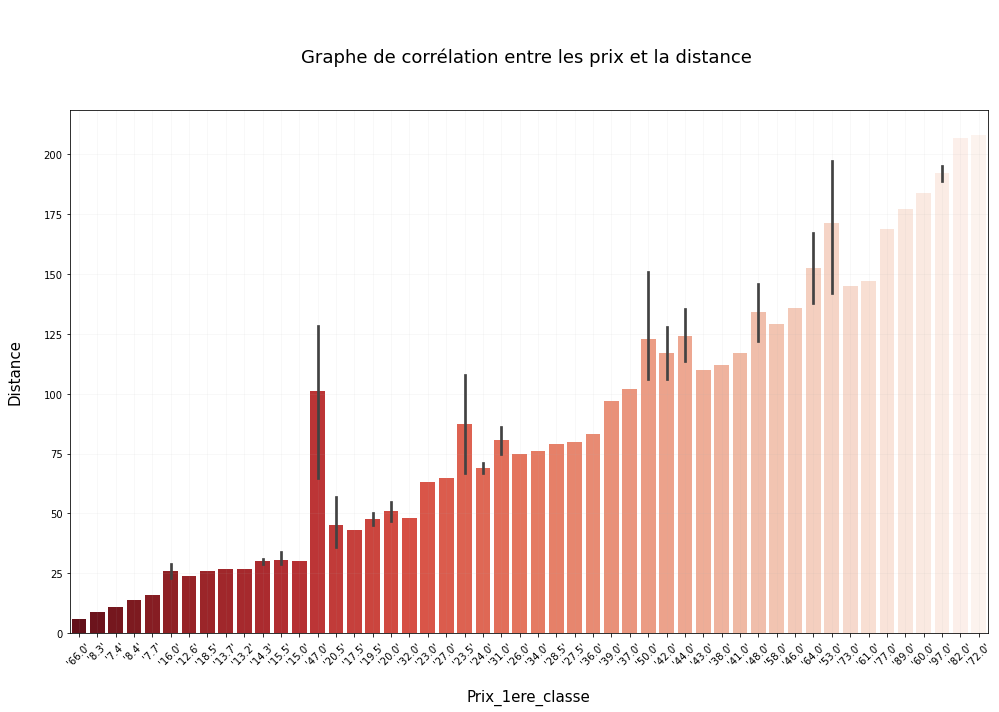

In [21]:
import seaborn as sns
plt.figure(figsize = (14,10))
sns.barplot(y = trajets_distances_prix['Distance'][:77], x = trajets_distances_prix["Prix_1ere_classe"][:77], palette="Reds_r")
plt.xlabel('\nPrix_1ere_classe', fontsize = 15, color = 'black')
plt.ylabel("Distance\n", fontsize = 15, color = 'black')
plt.title(" \n\nGraphe de corrélation entre les prix et la distance \n\n", fontsize = 18, color = 'black')
plt.xticks(rotation = 45)
#plt.grid(b=True, which='major', color='#666666', linestyle='-')
plt.grid(which = 'minor', alpha = 0.2)
plt.grid(which = 'major', alpha = 0.1)

plt.tight_layout()


Dans le cadre de l'exercice on voit bien que le prix en classe première n'est pas uniquement déterminé en fonction de la distance mais aussi en fonction de l'élasticité de la demande. 